### Learn computer vision learning tensorflow. Dataset is the dogs and cats image set from Kaggles image competition. Start by subsetting the image set and learn to optimize the model with a small amount of data.

In [4]:
import os, shutil, pathlib

original_dir = pathlib.Path("C:/Users/joshu/Documents/TensorFlow Learning Materials/dogs-vs-cats/train")
new_base_dir = pathlib.Path("C:/Users/joshu/Documents/TensorFlow Learning Materials/cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname, dst=dir / fname)

#2000 training, 1000 validation, 2000 test
make_subset("train", start_index = 0, end_index = 1000)
make_subset("validation", start_index = 1000, end_index = 1500)
make_subset("test", start_index = 1500, end_index = 2500)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Arbitrary choice to make images 180 x 180
inputs = keras.Input(shape = (180, 180, 3))
#rescale from 0-255 to 0-1
x = preprocessing.Rescaling(1./255)(inputs)
#start of layers
x = layers.Conv2D(filters=32, kernel_size=3, activation ="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

In [11]:
model.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])

In [13]:
#Can ease the preprocessing step using image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180,180),
    batch_size = 32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180,180),
    batch_size = 32)

#This creates a dataset object which can be passed directly into the fit method
#and can be iterated. There is a functional API for modifying. 

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [16]:
#Dataset object example
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000,16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [18]:
#can batch the data
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


### Can also perform: .shuffle(buffer_size) - shuffles elements w/in buffer. .prefetch(buffer_size) - prefetches a buffer of elements in GPU memory for better device utlization. .map(callable) - arbitrary transformation to each element in dataset. callable takes as input a single element yielded by the dataset.

In [19]:
#Common method is .map() which in this case reshapes dataset from shape (16,) to
# (4,4)
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4,4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [20]:
#display shapes/labels yielded by dataset object
for data_batch, labels_batch in train_dataset:
    print("data batch shape: ", data_batch.shape)
    print("labels batch shape: ", labels_batch.shape)
    break

data batch shape:  (32, 180, 180, 3)
labels batch shape:  (32,)


In [21]:
#Fit model using dataset object
callbacks = [keras.callbacks.ModelCheckpoint(
                filepath = "convnet_from_scratch.keras",
                save_best_only = True,
                monitor = "val_loss")]
history = model.fit(train_dataset, epochs = 30, 
                    validation_data = validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 18s 149ms/step - loss: 0.7077 - accuracy: 0.5040 - val_loss: 0.6913 - val_accuracy: 0.5750
Epoch 2/30
63/63 [==============================] - 6s 98ms/step - loss: 0.6970 - accuracy: 0.5480 - val_loss: 0.6791 - val_accuracy: 0.5830
Epoch 3/30
63/63 [==============================] - 6s 91ms/step - loss: 0.6814 - accuracy: 0.5740 - val_loss: 0.6744 - val_accuracy: 0.5900
Epoch 4/30
63/63 [==============================] - 6s 98ms/step - loss: 0.6302 - accuracy: 0.6460 - val_loss: 0.6848 - val_accuracy: 0.6320
Epoch 5/30
63/63 [==============================] - 8s 121ms/step - loss: 0.6108 - accuracy: 0.6825 - val_loss: 0.6489 - val_accuracy: 0.6280
Epoch 6/30
63/63 [==============================] - 7s 115ms/step - loss: 0.5721 - accuracy: 0.7075 - val_loss: 0.6236 - val_accuracy: 0.6610
Epoch 7/30
63/63 [==============================] - 7s 107ms/step - loss: 0.5288 - accuracy: 0.7505 - val_loss: 0.5816 - val_accuracy: 0.7110
Epoch 8/

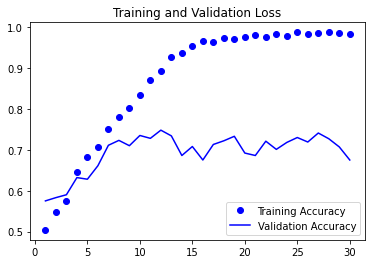

In [23]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label = "Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label = "Validation Accuracy")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [24]:
#Model is likely overfitting. Reload save file to check before it started overfitting
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 54ms/step - loss: 0.5839 - accuracy: 0.7170
Test accuracy: 0.717


### Data Augmentation
#### Used almost exclusivly for computer vision problems. Useful when the model is overfitting.

In [30]:
data_augmentation = keras.Sequential([
    #random 50% of images are randomly flipped horizontally
    preprocessing.RandomFlip(mode = "horizontal"),
    #randomly rotats teh input image by 1/10 of a full circle
    preprocessing.RandomRotation(0.1),
    #zoom in/out of image by 20% 
    preprocessing.RandomZoom(0.2),
])

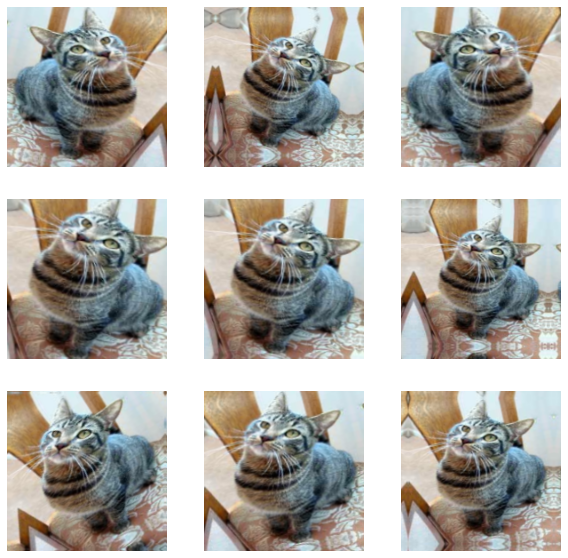

In [31]:
#Display augmented image example
plt.figure(figsize=(10, 10))
#.take(N) - samples N batchs from the dataset. equivalent to stopping loop w/ break after Nth batch
for images, _ in train_dataset.take(1):
    for i in range(9):
        #Apply augmentation
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        #Display first image in the output batch each of the 9 iterations is a differnt augmentation
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [35]:
#image augmentation is inactive when predicting, just like with dropout
#Use both augmentation and droupout
inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs = inputs, outputs = outputs)

In [37]:
model.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])

In [38]:
#train on longer epoch cycle since overfitting should occur much later
callbacks = [keras.callbacks.ModelCheckpoint(
            filepath = 'convnet_from_scratch_with_augmentatin.keras',
            save_best_only = True,
            monitor = "val_loss")]
history = model.fit(train_dataset, epochs=100, 
                    validation_data = validation_dataset,
                   callbacks = callbacks)

Epoch 1/100
63/63 [==============================] - 8s 110ms/step - loss: 0.9590 - accuracy: 0.5120 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 7s 103ms/step - loss: 0.7006 - accuracy: 0.5185 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 7s 113ms/step - loss: 0.7118 - accuracy: 0.5300 - val_loss: 0.6747 - val_accuracy: 0.5650
Epoch 4/100
63/63 [==============================] - 7s 114ms/step - loss: 0.6928 - accuracy: 0.5545 - val_loss: 0.8200 - val_accuracy: 0.4950
Epoch 5/100
63/63 [==============================] - 7s 103ms/step - loss: 0.6697 - accuracy: 0.6095 - val_loss: 0.6893 - val_accuracy: 0.5600
Epoch 6/100
63/63 [==============================] - 7s 102ms/step - loss: 0.6591 - accuracy: 0.6320 - val_loss: 0.6506 - val_accuracy: 0.6410
Epoch 7/100
63/63 [==============================] - 6s 101ms/step - loss: 0.6395 - accuracy: 0.6470 - val_loss: 0.6518 - val_accuracy: 0.6170

Epoch 58/100
63/63 [==============================] - 7s 101ms/step - loss: 0.2280 - accuracy: 0.9115 - val_loss: 0.6290 - val_accuracy: 0.8120
Epoch 59/100
63/63 [==============================] - 8s 123ms/step - loss: 0.2303 - accuracy: 0.9085 - val_loss: 0.5756 - val_accuracy: 0.8170
Epoch 60/100
63/63 [==============================] - 8s 126ms/step - loss: 0.2223 - accuracy: 0.9105 - val_loss: 0.5015 - val_accuracy: 0.8320
Epoch 61/100
63/63 [==============================] - 8s 122ms/step - loss: 0.2215 - accuracy: 0.9120 - val_loss: 0.4613 - val_accuracy: 0.8270
Epoch 62/100
63/63 [==============================] - 8s 119ms/step - loss: 0.2539 - accuracy: 0.9105 - val_loss: 0.6002 - val_accuracy: 0.8020
Epoch 63/100
63/63 [==============================] - 8s 120ms/step - loss: 0.2275 - accuracy: 0.9115 - val_loss: 0.7512 - val_accuracy: 0.8150
Epoch 64/100
63/63 [==============================] - 8s 119ms/step - loss: 0.2081 - accuracy: 0.9135 - val_loss: 0.6181 - val_accuracy:

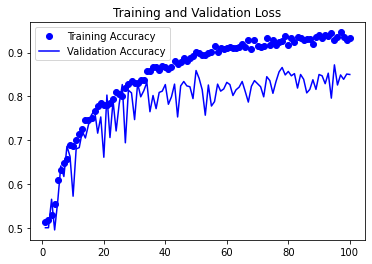

In [39]:
plt.clf()
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label = "Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label = "Validation Accuracy")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [41]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentatin.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc: .3f}")

63/63 [==============================] - 3s 35ms/step - loss: 0.4291 - accuracy: 0.8135
Test accuracy:  0.813


### Use a Pretrained Model to try and increase accuracy

In [42]:
#weights specifies the checkpoint to initialize model from
conv_base = keras.applications.vgg16.VGG16(weights = "imagenet",
#refers to including the densely connected classifier on top of the network (using my own)
                                          include_top = False,
#shape of image tensors (optional)
                                          input_shape=(180,180,3))

58892288/58889256 [==============================] - 1s 0us/step


In [43]:
#feature map shrinks to (5,5,512)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

### Method 1. Fast Feature Extraction without Data Augmentation

In [44]:
#Fast and cheap technqiue of recording output of conv_base on data and use outputs as inputs to a new model
import numpy as np
  
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
#of shape (samples, 5, 5, 512)
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [45]:
#define and train the densely connected classifier
inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs)
#training fast because only have two dense layers
x = layers.Dense(256)(x)
x = layers.Dense(0.5)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss = "binary_crossentropy",
             optimizer = "rmsprop",
             metrics = ["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras",
                                            save_best_only= True,
                                            monitor = "val_loss")]
history = model.fit(train_features, train_labels, epochs=20,
                   validation_data=(val_features, val_labels),
                   callbacks = callbacks)

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.4860 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4820 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4870 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/20
63/63 [=

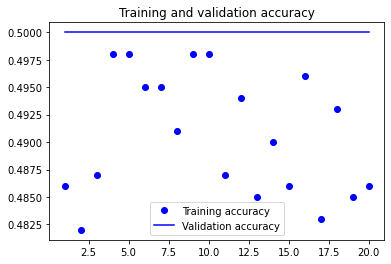

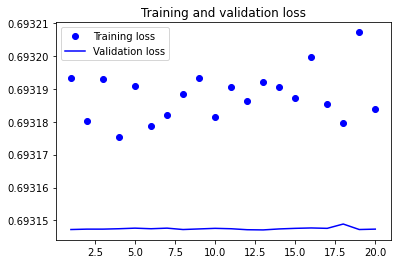

In [47]:
#Graphs dont look right but not sure where the issue is
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [48]:
#Feature extraction with data augmentation -- slower and more expensive
#Data aug w/ training that chains the conv_base with a new dense classifer making an end to end input
#freeze the conv_base layers so weights dont update.
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
#freezes the layer/model - empties the list of trainable weights 
conv_base.trainable = False

In [50]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180,180,3))
#data augmentation
x = data_augmentation(inputs)
#scales input values
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
#only weights from these dense layers are trained.
#total of four weigh tensors - two per layer (main matrix and bias vector)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss = "binary_crossentropy",
             optimizer = "rmsprop",
             metrics = ['accuracy'])

In [51]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 17s 255ms/step - loss: 17.3625 - accuracy: 0.9010 - val_loss: 3.4095 - val_accuracy: 0.9700
Epoch 2/50
63/63 [==============================] - 16s 251ms/step - loss: 8.5725 - accuracy: 0.9410 - val_loss: 4.5115 - val_accuracy: 0.9740
Epoch 3/50
63/63 [==============================] - 16s 249ms/step - loss: 6.4810 - accuracy: 0.9500 - val_loss: 2.7663 - val_accuracy: 0.9790
Epoch 4/50
63/63 [==============================] - 16s 250ms/step - loss: 4.5904 - accuracy: 0.9630 - val_loss: 3.1928 - val_accuracy: 0.9740
Epoch 5/50
63/63 [==============================] - 16s 251ms/step - loss: 5.2995 - accuracy: 0.9585 - val_loss: 4.0164 - val_accuracy: 0.9710
Epoch 6/50
63/63 [==============================] - 16s 260ms/step - loss: 3.4644 - accuracy: 0.9685 - val_loss: 3.9260 - val_accuracy: 0.9700
Epoch 7/50
63/63 [==============================] - 16s 256ms/step - loss: 3.6533 - accuracy: 0.9695 - val_loss: 2.5752 - val_accuracy: 0.980

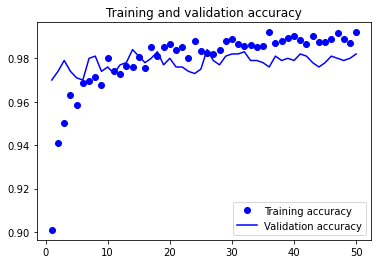

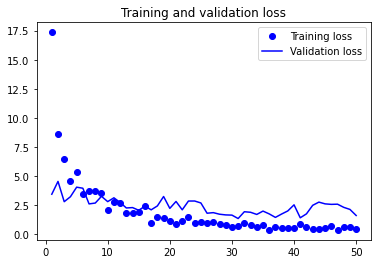

In [52]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [53]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 11s 163ms/step - loss: 1.8790 - accuracy: 0.9805
Test accuracy: 0.980


### Fine-tune the Model

In [54]:
#Fine-tune the model- unfreeze convo block 5 
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [55]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
#Dont want to unfreeze more layers because early ones are more generic/reusable compared to the higher up ones which are specialized
#these need to be repurposed in training

In [56]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
  
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 20s 282ms/step - loss: 0.3438 - accuracy: 0.9885 - val_loss: 1.6624 - val_accuracy: 0.9810
Epoch 2/30
63/63 [==============================] - 18s 278ms/step - loss: 0.2750 - accuracy: 0.9920 - val_loss: 1.5565 - val_accuracy: 0.9820
Epoch 3/30
63/63 [==============================] - 18s 278ms/step - loss: 0.5432 - accuracy: 0.9885 - val_loss: 2.0180 - val_accuracy: 0.9790
Epoch 4/30
63/63 [==============================] - 17s 275ms/step - loss: 0.4981 - accuracy: 0.9905 - val_loss: 1.8469 - val_accuracy: 0.9820
Epoch 5/30
63/63 [==============================] - 17s 276ms/step - loss: 0.3939 - accuracy: 0.9885 - val_loss: 1.5192 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 17s 276ms/step - loss: 0.1709 - accuracy: 0.9945 - val_loss: 1.3781 - val_accuracy: 0.9850
Epoch 7/30
63/63 [==============================] - 17s 276ms/step - loss: 0.4040 - accuracy: 0.9900 - val_loss: 1.3630 - val_accuracy: 0.9820

In [57]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 10s 161ms/step - loss: 1.2928 - accuracy: 0.9795
Test accuracy: 0.979
